In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# RP generator

Damped Random Walk (Matthew's code)

In [6]:
def getDRWMag(tau, SFinf, mag_prev, dt):
  loc = mag_prev * np.exp(-dt / tau)
  scale = SFinf * np.sqrt((1. - np.exp(-2. * dt / tau)) / 2.)
  return loc + np.random.normal(0., scale)

In [7]:
def generateDRW(t, tau, SFinf = 0.3, xmean = 0, burn = 10000):
  # Generate in rest frame
  n = len(t)
  dt = np.diff(t)
  mag = np.zeros(n)
  mag[0] = np.random.normal(0, SFinf / np.sqrt(2.))
  for i in range(burn):
    mag[0] = getDRWMag(tau, SFinf, mag[0], dt[np.random.randint(n - 1)])
  for i in range(n - 1):
    mag[i + 1] = getDRWMag(tau, SFinf, mag[i], dt[i])
  return xmean + mag

General time series generation

In [10]:
def generate_time_series(process: str, 
                         N: int = 1000,
                         amplitude: float = 1.0,        
                         mu_dt: float = 5.0,
                         sigma_dt: float = 0.3,  
                         drop_frac: float = 0.0,  
                         noise_sigma: float = 0.1, 
                         mag_err_sigma: float = 0.05,  
                         phi: float = 0.9,
                         # specific for DRW:
                         tau_drw: float = 50.0,
                         SFinf: float = 0.3,
                         burn: int = 10000,
                         seed: int = None) -> pd.DataFrame:
    
    """
    Generate synthetic time series for different signal types

    Parameters:
    - process: Type of base signal ('sin', 'square', 'random', 'red', 'DRW')
    - N: Number of data points
    - mu_dt: Mean time step
    - sigma_dt: Std. deviation of time step
    - drop_frac: Fraction of points to randomly drop to simulate gaps
    - noise_sigma: Noise added on top of clean signal
    - mag_err_sigma: Std. deviation of reported magnitude errors
    - phi: AR(1) coefficient for red noise
    - seed: Random seed for reproducibility

    Returns:
    - DataFRame with time, magnitude, and magnitude error
    """

    rng = np.random.default_rng(seed)
    dt = rng.normal(loc=mu_dt, scale=sigma_dt, size=N)
    time = np.cumsum(dt)

    # Randomly drop some timestamps to simulate observational gaps
    if drop_frac > 0:
        mask = rng.random(time.shape[0]) > drop_frac
        time = time[mask]   


    t_norm = 2 * np.pi * (time - time.min()) / (time.max() - time.min()) 

    # Generate base signal
    if process == 'sin': 
        mag_base = np.sin(t_norm)
    elif process == 'square':
        mag_base = np.sign(np.sin(t_norm))
    elif process == 'random':   # white noise
        mag_base = rng.normal(0, 1, size=len(time))
    elif process == 'red':
        mag_base = np.zeros(len(time))
        mag_base[0] = rng.normal(0,1)
        for i in range (1, len(time)):
            mag_base[i] = phi * mag_base[i-1] + rng.normal(0,1)
    elif process == 'drw':
        mag_base = generateDRW(time, tau=tau_drw, SFinf=SFinf, burn=burn)

    else:
        raise ValueError("process must be one of: 'sin', 'square', 'random', 'red', 'drw'")
    
    if process != 'drw':
    # Add Gaussian observational noise to the signal
        mag = amplitude * mag_base + rng.normal(0, noise_sigma, size=len(time))
    else:
        mag = amplitude * mag_base
    
    # Generate magnitude errors
    mag_err = np.abs(rng.normal(0, mag_err_sigma, size=len(time)))

    return pd.DataFrame({'time': time, 'mag': mag, 'mag_err': mag_err})

Time Delay Embedding (Takens Embedding)

In [11]:
def embed_series(x, m, tau): 
    """
    Perform Takens' time-delay embedding of a 1D time series

    Parameters:
    - x: 1D time series array
    - m: Embedding dimension
    - tau: Time delay between embedded components

    Returns:
    - 2D array of shape (M, m), the embedded vectors
    """

    N = len(x)
    M = N - (m-1) * tau  
    return np.array([x[i : i + m * tau : tau] for i in range(M)])


Recurrence Plot

In [12]:
def recurrence_plot(df, m=2, tau=1, eps=None, perc=None, save_path=None, show=False):
    """
    Compute and display a recurrence plot of a time series

    Parameters:
    - df: DataFrame with 'mag' column representing the time series
    - m: Embedding dimension
    - tau: Time delay
    - eps: Distance threshold for recurrence (optional)
    - perc: Percentile to determine eps if not explicitly set

    Returns:
    - Binary recurrence matrix (1 for recurrence, 0 otherwise)
    """

    x = df['mag'].values
    emb = embed_series(x, m, tau)

    # Compute pairwise Euclidean distances between embedded vectors
    D = np.sqrt(((emb[:, None, :] - emb[None, :, :])**2).sum(axis=2))

    # Set threshold distance for recurrence based on percentile or median
    if eps is None:
        if perc is not None:
            eps = np.percentile(D, perc)
        else:
            eps = np.median(D)

    # Binary recurrence matrix
    R = (D <= eps).astype(int)

    plt.figure(figsize=(6,6))
    plt.imshow(R, origin='lower', cmap='Greys', interpolation='none')
    plt.xlabel('Embedding index')
    plt.ylabel('Embedding index')
    plt.title(r'Recurrence Plot ($m$=%d, $\tau$=%d, $\epsilon$=%.2f)' % (m, tau, eps))
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    elif show:
        plt.show()
    else:
        plt.close()

    return R, eps

# Testing

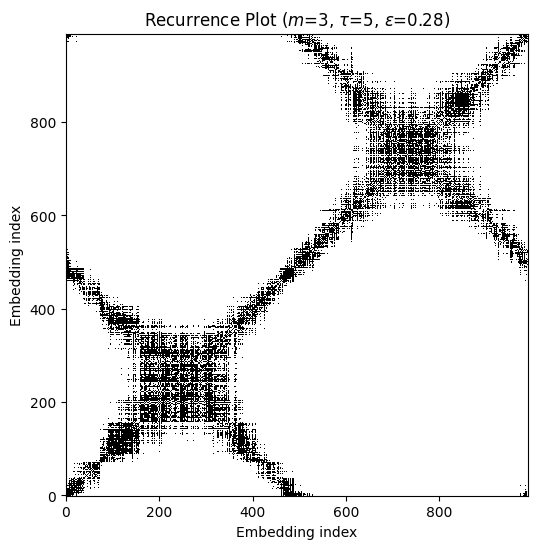

In [42]:
df_sin = generate_time_series('sin', N=1000, drop_frac=0.0, seed=0)
R_sin = recurrence_plot(df_sin, m=3, tau=5, perc=10, show=True)

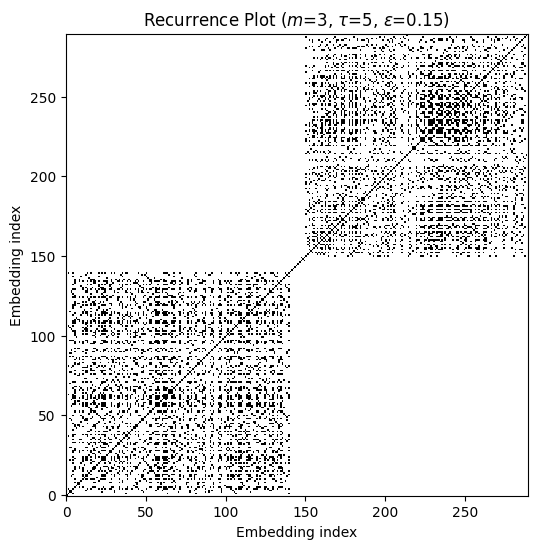

In [48]:
df_sqr = generate_time_series('square', N=300, drop_frac=0.0, seed=10)
R_sqr = recurrence_plot(df_sqr, m=3, tau=5, perc=10, show=True)

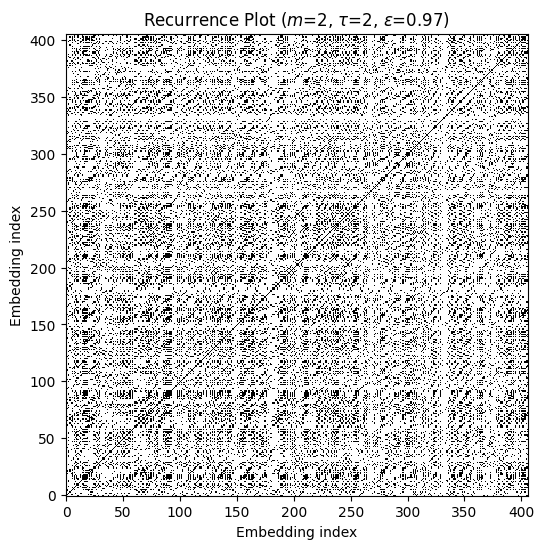

In [54]:
df_random = generate_time_series('random', N=500, drop_frac=0.2, seed=2)
R_random = recurrence_plot(df_random, m=2, tau=2, perc=20, show=True)

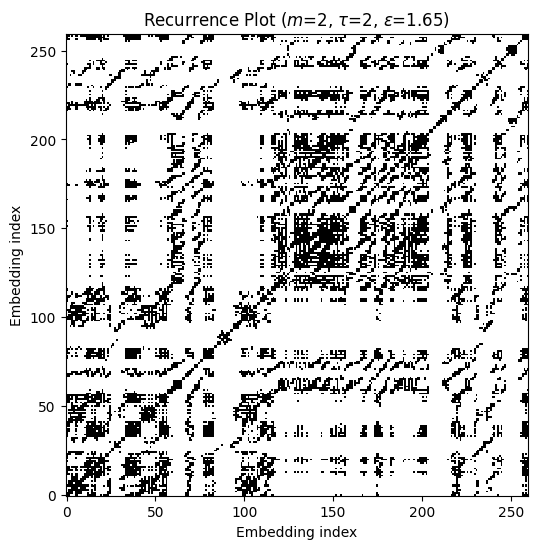

In [59]:
df_red = generate_time_series('red', N=300, drop_frac=0.1, seed=3)
R_red = recurrence_plot(df_red, m=2, tau=2, perc=20, show=True)

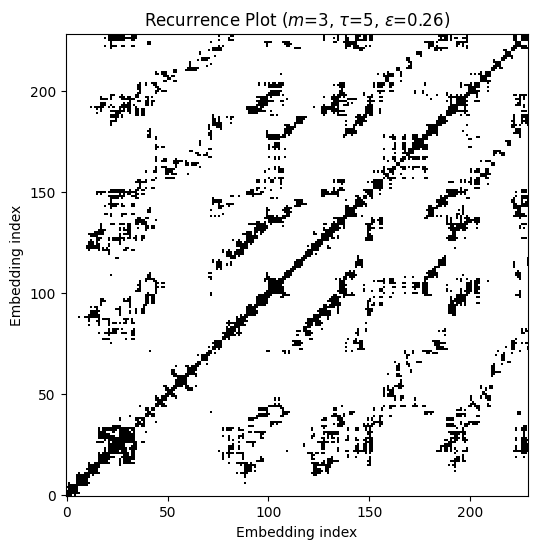

In [75]:
df_drw = generate_time_series('drw', N=300, drop_frac=0.2, seed=42, tau_drw=100.0, SFinf=0.5, burn=5000)
R_drw = recurrence_plot(df_drw, m=3, tau=5, perc=10, show=True)

# Batch generation

In [15]:
def generate_dataset(signal_type='sin',
                     num_samples=100,
                     output_dir='dataset/dataset_out',
                     tau_drw=50.0,
                     SFinf=0.3,
                     burn=10000,
                     m_fixed=None,
                     tau_fixed=None,
                     perc_fixed=None,
                     amplitudes=(1.0,)):  
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(f"{output_dir}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/arrays", exist_ok=True)
    
    metadata = []
    for i in range(num_samples):
        seed = i

        amp = amplitudes[i % len(amplitudes)]
        m = m = m_fixed if m_fixed is not None else np.random.randint(2, 11)
        perc = perc_fixed if perc_fixed is not None else np.random.choice([5, 10, 15, 20])
        
        if tau_fixed is not None:
            tau = int(tau_fixed)
        elif signal_type == 'drw':
            tau = int(tau_drw)
        else:
            tau = np.random.randint(2, 61)

        df = generate_time_series(signal_type, seed=seed, tau_drw=tau_drw, SFinf=SFinf, burn=burn, amplitude=amp)
        R, eps = recurrence_plot(df, m=m, tau=tau, perc=perc, show=False)

        # Save image
        img_path = f"{output_dir}/images/{signal_type}_{i:03d}.png"
        plt.imsave(img_path, R, origin='lower', cmap='gray')

        # Save array
        npy_path = f"{output_dir}/arrays/{signal_type}_{i:03d}.npy"
        np.save(npy_path, R)

        # Save metadata
        metadata.append({
            'index': i,
            'signal_type': signal_type,
            'm': m,
            'tau': tau,
            'eps': eps,
            'amplitude': amp,
            'perc': perc,
            'seed': seed,

        })
    
    df_meta = pd.DataFrame(metadata)
    meta_csv_path = f"{output_dir}/metadata.csv"
    df_meta.to_csv(meta_csv_path, index=False)
    return df_meta

# Generate dataset

In [17]:
signal_types = ['sin', 'square', 'random', 'red', 'drw']
num_samples = 100

for signal in signal_types:
    print(f"Generating dataset for: {signal}")
    output_dir = f'dataset/{signal}'

    generate_dataset(signal_type=signal, 
                     num_samples=num_samples,
                     output_dir=output_dir,
                     m_fixed=3,
                     tau_fixed=5, 
                     perc_fixed=10, 
                     amplitudes=(0.5,1.0,1.5,2.0))

Generating dataset for: sin
Generating dataset for: square
Generating dataset for: random
Generating dataset for: red
Generating dataset for: drw


In [ ]:
"""
signal_types = ['sin', 'square', 'random', 'red', 'drw']
num_samples = 10

for signal in signal_types:
    print(f"Generating dataset for: {signal}")
    output_dir = f'dataset/dataset_out/{signal}'

    generate_dataset(signal_type=signal, 
                     num_samples=num_samples,
                     output_dir=output_dir,
                     m_fixed=3,
                     tau_fixed=5, 
                     perc_fixed=10, 
                     amplitudes=(0.5,1.0,1.5,2.0))
"""

Generating dataset for: sin
Generating dataset for: square
Generating dataset for: random
Generating dataset for: red
Generating dataset for: drw
